# Compare prediction performance of OGTT glucose AUC using 5 different X datasets:
1. All individual samples (n=30)
2. All samples averaged (n=10)
3. Week 8  (n=10)
4. Week 9  (n=10)
5. Week 10 (N=10)

## Comparison will be used to inform which samples we should use for the followup/validation 

### We should get the extra 6 rats from the same 1070-1100 rat numbering range
### We should also get the 5 males and 3 females in the cohort in 1700 range 

In [1]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-white')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LarsCV, LassoCV, LinearRegression, RidgeCV, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [30]:
y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

In [119]:
n_repeats, n_splits = 200, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
models = {
    'ols': (LinearRegression(), X_scaled),
#     'lasso': (Lasso(alpha=483), X_scaled), # Lasso hyperparameter alpha found from LassoCV
#     'ridge': (Ridge(), X_scaled),
#     'svm': (SVR(kernel='linear', C=1), X_scaled),
#     'pls': (PLSRegression(), X),
#     'rf': (RandomForestRegressor(n_estimators=200, max_features=100, random_state=42), X),
}
y = {
    'ogtt': y_ogtt,
#     'insulin': y_insulin,
#     'weight': y_weight,
}
Xs = {
    'all':  data[rbg_cols].T,
    'avg':  data[rbg_cols].groupby(fg['animal'], axis=1).mean().T,
    'wk8':  data[fg.loc[(fg['week'] == 8) & (fg['bg_type'] == 'RBG')].index].T,
    'wk9':  data[fg.loc[(fg['week'] == 9) & (fg['bg_type'] == 'RBG')].index].T,
    'wk10': data[fg.loc[(fg['week'] ==10) & (fg['bg_type'] == 'RBG')].index].T,
}

for key, value in Xs.items(): 
    Xs[key] = pd.DataFrame(StandardScaler().fit_transform(Xs[key]), 
                           index=Xs[key].index.astype('str').str.split('_').str[0],
                           columns=Xs[key].columns)
    
animal_ogtt_dict = dict(zip(fg['animal'], fg['ogtt']))

In [122]:
results = {}
for X, X_data in Xs.items(): 
    print(X)
    crossval = cross_validate(
        estimator=LinearRegression(),
        X=X_data,
        y=X_data.index.astype('int').map(animal_ogtt_dict),
        cv=cv,
        n_jobs=7,
        scoring=scoring,
#         scoring='neg_mean_squared_error'
    )
    results[X] = crossval

all
avg
wk8
wk9
wk10


In [129]:
r = []
for X, result in results.items():
    df = pd.DataFrame(result)
    df['X'] = X
    r.append(df)
r = pd.concat(r)
r['test_neg_mean_squared_error'] = -1 * r['test_neg_mean_squared_error'] 
r

,fit_time,score_time,test_neg_mean_squared_error,test_r2,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,X
0,0.026737,0.028000,3.598832e+07,0.522616,-0.129547,-5999.026418,all
1,0.025998,0.024004,3.805776e+07,0.847003,-0.145158,-6169.096907,all
2,0.026999,0.023998,2.902968e+07,0.804603,-0.120860,-5387.920173,all
3,0.027003,0.025995,7.064641e+07,0.675018,-0.250366,-8405.141735,all
4,0.025999,0.023000,3.423022e+07,0.628688,-0.115897,-5850.659853,all
...,...,...,...,...,...,...,...
995,0.024803,0.026998,5.660843e+06,0.898858,-0.093652,-2379.252708,wk10
996,0.025001,0.026998,3.725678e+07,-69.394593,-0.101955,-6103.833089,wk10
997,0.026998,0.026000,1.427202e+08,-3.314803,-0.220688,-11946.555702,wk10
998,0.022997,0.024998,9.373073e+07,-0.076759,-0.283847,-9681.463064,wk10


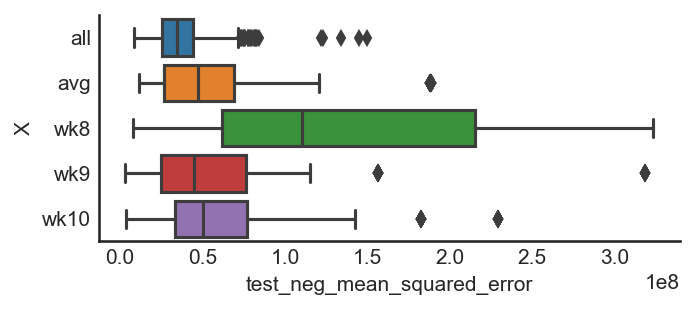

In [136]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 2), facecolor='white')
sns.boxplot(
    data=r, x='test_neg_mean_squared_error', y='X', orient='h'
)
sns.despine()



In [148]:
np.trapz(x=[0, 10, 20, 30, 60, 120], y=[81, 135, 194.5, 246, 296, 261.5])

29785.0

In [147]:
len(set(results['avg']['test_neg_mean_squared_error']))

45